# EXAMPLE ON HOW TO GET THE HYBRID BIAS FIELD-LEVEL RESULTS FROM MAP2MAP

Hellooooooo Kate! I hope everything is going wonderful! 

Here I summarise the codes I used to get the field level results with the map2map emulator.

## Some steps prior to computing the fields of the hybrid model

1. First, one needs to have the displacement fields from a Zeldovich simulation and (in case you'd like to compare against a full N-body) from their correspondant N-body simulation, and the linear density field of such simulation (this is for later). Since the map2map emulator was trained on the Quijote simulations, I have prepared one such simulations in the following folder at the atlas cluster (I hope you have access to it, otherwise let me know and I will send you the files):

**N-body displacement: /dipc_storage/mpelle/Yin_data/Fiducial/Quijote/200/**

**ZA displacement: /dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/**

**Linear density: /dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/den_200.npy**

(Note that /dipc_storage/ is called like that only from our node, atlas-248. From the normal atlas log-in nodes it is just called /dipc/).

2. Once you have the ZA displacement field, you will need to install the map2map emulator from Drew's github repository:

https://github.com/dsjamieson/map2map_emu/

3. To get the emulated displacement field, just run the line (changing the paths to wherever you have the files):

```shell
python m2m.py test --test-in-patterns "/dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/dis_200.npy" --test-tgt-patterns "/dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/dis_200.npy" --in-norms "cosmology.dis" --tgt-norms "cosmology.dis" --crop 128 --crop-step 128 --pad 48 --model d2d.StyledVNet --batches 1 --loader-workers 7 --load-state "map2map/weights/d2d_weights.pt" --callback-at "/scratch/mpelle/CodesPostdocDIPC/map2map_emu/" --test-style-pattern "/scratch/mpelle/CodesPostdocDIPC/map2map_emu/style_fyle.txt"
```
I know this is a very confusing line if it is the first time that you see it. Let me know if you have any trouble. The "style_fyle.txt" is a file that the user has to create containing the Om value of the simulation. Since I used the Quijote fiducial cosmology for this example, it is Om=0.3175. It only contains the number, not the "Om=".
The output of this code will be writen in a file called "._out.npy" so you won't be able to see it with a simple ls!!! Once you run it, just move it with the name you prefer, in our case:
```shell
mv ._out.npy emu_disp.npy
```
Now that we have the emulation and the N-body result, we can compute the fields. 

## Computing the emulated fields 

1. We have to load some modules first and set uo a couple of options for the bacco code

In [1]:
import numpy as np
import bacco
import os
import copy
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import deepdish as dd

ngrid = 512 #1024 #512 #256 #128 #256 #1400
nmean=0.01
BoxSize=1000

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}})
bacco.configuration.update({'pknbody' : {'interlacing' : False}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


2. We create a uniform grid of particles as the Initial Conditions of our emulated simulation

In [ ]:
grid = bacco.visualization.uniform_grid(npix=ngrid, L=BoxSize, ndim=3, bounds=False)

3. We read the emulated displacement and move the particles

In [3]:
pred_disp = np.load('../emu_disp.npy')

pred_pos = bacco.scaler.add_displacement(None,
                             pred_disp,
                             box=BoxSize,
                             pos=grid.reshape(-1,3),
                             vel=None,
                             vel_factor=0,
                             verbose=True)[0]

2023-11-08 18:59:19,222 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Now we have the emulated positions coming from map2map :)

4. We take this emulated simulation and compute the fields that will be used for the hybrid model. To do this we also need the linear density field of the Quijote simulation.

We read the linear density field of the Quijote simulation:

In [4]:
dens_yin = np.load('/dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/den_200.npy')

Then initialise the hybrid bias class:

In [5]:
k_nyq = np.pi * ngrid / BoxSize

damping_scale = k_nyq

bmodel = bacco.BiasModel(sim=None, linear_delta=dens_yin[0], ngrid=ngrid, ngrid1=ngrid,
                         sdm=True, mode="dm", BoxSize=BoxSize,
                         npart_for_fake_sim=ngrid, damping_scale=damping_scale,
                         bias_model='expansion', deposit_method="cic",
                         use_displacement_of_nn=False, interlacing=False,
                         )

2023-11-08 18:59:41,434 bacco.BiasModel : Initialising Bias Model class ...


Ask the bias class to compute the bias fields in Lagrangian coordinates:

In [6]:
bias_fields = bmodel.bias_terms_lag()

2023-11-08 18:59:48,364 bacco.BiasModel : Computing delta_to_tidal_field with 12 threads...
2023-11-08 18:59:48,365 bacco.BiasModel : fttw plan
2023-11-08 18:59:48,366 bacco.BiasModel : Computing linear field ...
2023-11-08 18:59:48,367 bacco.BiasModel : Memory used: 6.585475072 Gigabytes
2023-11-08 18:59:48,375 bacco.BiasModel : fttw freqs
2023-11-08 18:59:48,375 bacco.BiasModel : tidk freqs
2023-11-08 18:59:53,910 bacco.BiasModel : ifft
2023-11-08 19:00:26,619 bacco.BiasModel : Computing laplacian ...
2023-11-08 19:00:26,622 bacco.BiasModel : Memory used: 11.424714752 Gigabytes
2023-11-08 19:00:27,863 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2023-11-08 19:00:27,867 bacco.BiasModel : Memory used: 11.961049088 Gigabytes
2023-11-08 19:00:28,021 bacco.BiasModel : Computing delta squared ...
2023-11-08 19:00:28,022 bacco.BiasModel : Memory used: 12.497895424 Gigabytes
2023-11-08 19:00:28,724 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2

Weight the emulated positions by the lagrangian fields: 

In [7]:
bias_terms_eul_pred=[]
for ii in range(0,len(bias_fields)):
    bias_terms_pred = bacco.statistics.compute_mesh(ngrid=ngrid, box=BoxSize, pos=pred_pos,
                              mass = (bias_fields[ii]).flatten(), deposit_method='cic',
                              interlacing=False)
    bias_terms_eul_pred.append(bias_terms_pred)
bias_terms_eul_pred = np.array(bias_terms_eul_pred)

2023-10-23 18:13:15,708 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-10-23 18:13:15,709 bacco.statistics : starting deposit 1
2023-10-23 18:13:16,859 bacco.statistics :  mesh done in 1.15 s
2023-10-23 18:13:17,099 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-10-23 18:13:17,100 bacco.statistics : starting deposit 1
2023-10-23 18:13:18,238 bacco.statistics :  mesh done in 1.14 s
2023-10-23 18:13:18,475 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-10-23 18:13:18,477 bacco.statistics : starting deposit 1
2023-10-23 18:13:19,577 bacco.statistics :  mesh done in 1.1 s
2023-10-23 18:13:19,813 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-10-23 18:13:19,814 bacco.statistics : starting deposit 1
2023-10-23 18:13:20,915 bacco.statistics :  mesh done in 1.1 s
2023-10-23 18:13:21,155 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
202

5. We repeat the same procedure but with the Quijote displacements to get the N-body results:

In [8]:
sim_disp = np.load('/dipc_storage/mpelle/Yin_data/Fiducial/Quijote/200/dis_200.npy')

sim_pos = bacco.scaler.add_displacement(None,
                             sim_disp,
                             box=BoxSize,
                             pos=grid.reshape(-1,3),
                             vel=None,
                             vel_factor=0,
                             verbose=True)[0]

2023-10-23 18:13:24,230 bacco.scaler : Adding displacement field with a vel-factor=0.000000


In [9]:
bias_terms_eul_sim=[]
for ii in range(0,len(bias_fields)):
    bias_terms_sim = bacco.statistics.compute_mesh(ngrid=ngrid, box=BoxSize, pos=sim_pos,
                              mass = (bias_fields[ii]).flatten(), deposit_method='cic',
                              interlacing=False)
    bias_terms_eul_sim.append(bias_terms_sim)
bias_terms_eul_sim = np.array(bias_terms_eul_sim)

2023-10-23 18:13:25,735 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-10-23 18:13:25,736 bacco.statistics : starting deposit 1
2023-10-23 18:13:26,857 bacco.statistics :  mesh done in 1.12 s
2023-10-23 18:13:27,119 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-10-23 18:13:27,122 bacco.statistics : starting deposit 1
2023-10-23 18:13:28,256 bacco.statistics :  mesh done in 1.14 s
2023-10-23 18:13:28,495 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-10-23 18:13:28,496 bacco.statistics : starting deposit 1
2023-10-23 18:13:29,617 bacco.statistics :  mesh done in 1.12 s
2023-10-23 18:13:29,858 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-10-23 18:13:29,859 bacco.statistics : starting deposit 1
2023-10-23 18:13:30,984 bacco.statistics :  mesh done in 1.13 s
2023-10-23 18:13:31,221 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2

Let's plot a couple of them to check that everything went as expected:

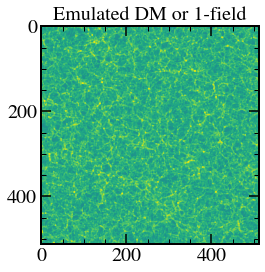

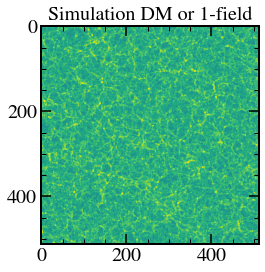

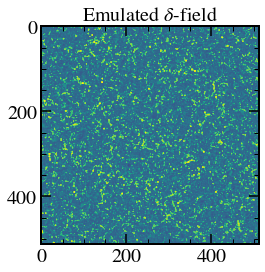

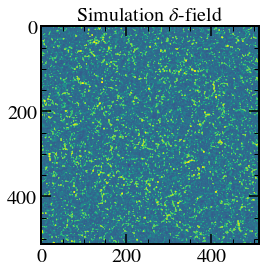

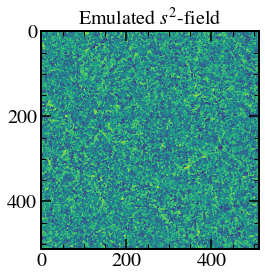

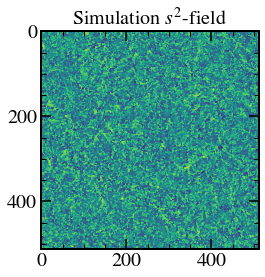

In [10]:
# Set normalisation
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-100.0, vmax=100.0)

#Plot 1-term
plt.imshow(bias_terms_eul_pred[0][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated DM or 1-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[0][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation DM or 1-field', size=20)
plt.show()

#Plot delta-term
plt.imshow(bias_terms_eul_pred[1][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated $\delta$-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[1][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation $\delta$-field', size=20)
plt.show()

#Plot tidal-term
plt.imshow(bias_terms_eul_pred[3][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated $s^2$-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[3][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation $s^2$-field', size=20)
plt.show()

#### Everything looks good so far! I am as surprised as you are :)

## Computing the emulated spectra

Let's see what the results are from a more quantitative point of view. Let's compute their power spectra and compare N-body versus emulated results.

1. We need to define the arguments for the power spectrum computation within bacco (but you can use any power spectrum calculator of course).

In [11]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob,
        hubble=hubble,
        ns=ns,
        sigma8=sigma8,
        tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )


cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

##################

# These are the important arguments of the P(k)
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':False,
                  'kmin':0.01,
                  'kmax':1,
                  'nbins':50,
                  'correct_grid':True,
                  'log_binning':True,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'compute_power2d':False}


#This is what I was talking about some corrections one can make to the P(k) computation
#Not very important though, ask Raul if you want to know more
lt_k = np.logspace(np.log10(np.pi / BoxSize), np.log10(2 * np.pi / BoxSize * ngrid), num=90)
pk_lpt = bacco.utils.compute_pt_15_basis_terms(cosmo_Quijote, expfactor=cosmo_Quijote.expfactor, wavemode=lt_k)

#Normalise the grid before P(k) computation
#one can normalise later too, I chose to do it here
norm=ngrid**3.
bias_terms_eul_norm_pred = bias_terms_eul_pred/norm


2023-10-23 18:13:35,040 bacco.cosmo :    initialization took 0.000 secs
2023-10-23 18:13:35,281 bacco.cosmo :    computed CLASS power spectrum at z=0.00 in 0.145 secs
2023-10-23 18:13:35,285 bacco.cosmo :    created Pk(z=0) tab from k 0.0006710999999999999 to 100000.0 h/Mpc


2. And compute the power spectrum of the 15 auto and cross terms

In [12]:

#Compute a dummy variable with the 15 combinations of 5 distinct objects
import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul_pred.shape[0]),r=2)))

#Compute the P(k) of the 15 terms
power_all_terms_pred = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True

    power_term_pred = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm_pred[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm_pred[prod[ii,1]],
                                                    normalise_grid1=False,
                                                    normalise_grid2=False,
                                                    deconvolve_grid1=True,
                                                    deconvolve_grid2=True,
                                                    **args_power)
    power_all_terms_pred.append(power_term_pred)


2023-10-23 18:13:38,504 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:13:38,510 bacco.cosmo :    computed halofit at z=0.00 for 'cosmo_BOSS' in 0.003 secs
/lscratch/mpelle/baccogit/bacco/statistics.py:1098: RuntimeWarning: divide by zero encountered in true_divide
  pk_gaussian_error = pk * np.sqrt(2.0 / nmodes)
/lscratch/mpelle/baccogit/bacco/statistics.py:1098: RuntimeWarning: invalid value encountered in multiply
  pk_gaussian_error = pk * np.sqrt(2.0 / nmodes)
2023-10-23 18:13:40,212 bacco.statistics :  ...done in 1.71 s
2023-10-23 18:13:40,213 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:13:41,922 bacco.statistics :  ...done in 1.71 s
2023-10-23 18:13:41,923 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:13:43,627 bacco.statistics :  ...done in 1.7 s
2023-10-23 18:13:43,629 bacco.statistics : Computing the power spectrum wit

bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
bacco

2023-10-23 18:13:45,316 bacco.statistics :  ...done in 1.69 s
2023-10-23 18:13:45,317 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:13:46,992 bacco.statistics :  ...done in 1.67 s
2023-10-23 18:13:46,994 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:13:48,672 bacco.statistics :  ...done in 1.68 s
2023-10-23 18:13:48,674 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:13:50,359 bacco.statistics :  ...done in 1.69 s
2023-10-23 18:13:50,361 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:13:52,043 bacco.statistics :  ...done in 1.68 s
2023-10-23 18:13:52,044 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:13:53,751 bacco.statistics :  ...done in 1.71 s
2023-10-23 18:13:53,753 bacco.statistics : Computing the power spectrum with ngrid=

ocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -6.91625e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.353279 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.348104 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000936 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1.34265e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.358235 sec
bacco.power : Counting modes
bacco.powe

2023-10-23 18:13:57,143 bacco.statistics :  ...done in 1.69 s
2023-10-23 18:13:57,144 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


r : done counting modes in 0.353651 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000584 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 2.18826e-10 (grid1) 2.18826e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.361045 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.355726 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000304 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1


2023-10-23 18:13:58,868 bacco.statistics :  ...done in 1.72 s
2023-10-23 18:13:58,869 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:00,568 bacco.statistics :  ...done in 1.7 s
2023-10-23 18:14:00,569 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:02,286 bacco.statistics :  ...done in 1.72 s
2023-10-23 18:14:02,288 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:03,961 bacco.statistics :  ...done in 1.67 s


3. We repeat the same for the Quijote N-body results

In [13]:
#Normalise the grid before P(k) computation
norm=ngrid**3.
bias_terms_eul_norm_sim = bias_terms_eul_sim/norm

#Compute the P(k) of the 15 terms
power_all_terms_sim = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True

    power_term_sim = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm_sim[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm_sim[prod[ii,1]],
                                                    normalise_grid1=False,
                                                    normalise_grid2=False,
                                                    deconvolve_grid1=True,
                                                    deconvolve_grid2=True,
                                                    **args_power)
    power_all_terms_sim.append(power_term_sim)


2023-10-23 18:14:04,873 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:06,579 bacco.statistics :  ...done in 1.71 s
2023-10-23 18:14:06,581 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:08,246 bacco.statistics :  ...done in 1.67 s
2023-10-23 18:14:08,247 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.56299e-05 (grid1) -6.91625e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.355936 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.362630 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000322 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.56299e-05 (grid1) 1.34265e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.367009 sec
bacco.power : Counting modes
bacco.power : done counti

2023-10-23 18:14:09,898 bacco.statistics :  ...done in 1.65 s
2023-10-23 18:14:09,900 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


ng modes in 0.343020 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000882 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -6.91625e-06 (grid1) -6.91625e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.367083 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.356478 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000322 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power :

2023-10-23 18:14:11,579 bacco.statistics :  ...done in 1.68 s
2023-10-23 18:14:11,579 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:13,252 bacco.statistics :  ...done in 1.67 s
2023-10-23 18:14:13,259 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:14,919 bacco.statistics :  ...done in 1.66 s
2023-10-23 18:14:14,920 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:16,611 bacco.statistics :  ...done in 1.69 s
2023-10-23 18:14:16,612 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:18,293 bacco.statistics :  ...done in 1.68 s
2023-10-23 18:14:18,294 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:19,956 bacco.statistics :  ...done in 1.66 s
2023-10-23 18:14:19,957 bacco.statistics : Computing the power spectrum with ngrid=

ng 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -1.563e-05 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.359308 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.337536 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000236 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -6.9163e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.356649 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.360642 sec
bacco.power : Starting Fourier loop 
bacco.po

2023-10-23 18:14:21,623 bacco.statistics :  ...done in 1.67 s
2023-10-23 18:14:21,624 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


o.power: FFT took 0.354494 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.343324 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000245 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3.76735e-11 (grid1) -1.563e-05 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.359290 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.367389 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000585 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : norma

2023-10-23 18:14:23,318 bacco.statistics :  ...done in 1.69 s
2023-10-23 18:14:23,321 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:25,004 bacco.statistics :  ...done in 1.68 s
2023-10-23 18:14:25,005 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:26,700 bacco.statistics :  ...done in 1.7 s
2023-10-23 18:14:26,701 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:28,383 bacco.statistics :  ...done in 1.68 s
2023-10-23 18:14:28,396 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-10-23 18:14:30,067 bacco.statistics :  ...done in 1.67 s


4. And we plot them to see how accurate the map2map emulator is in the 2-point statistics:

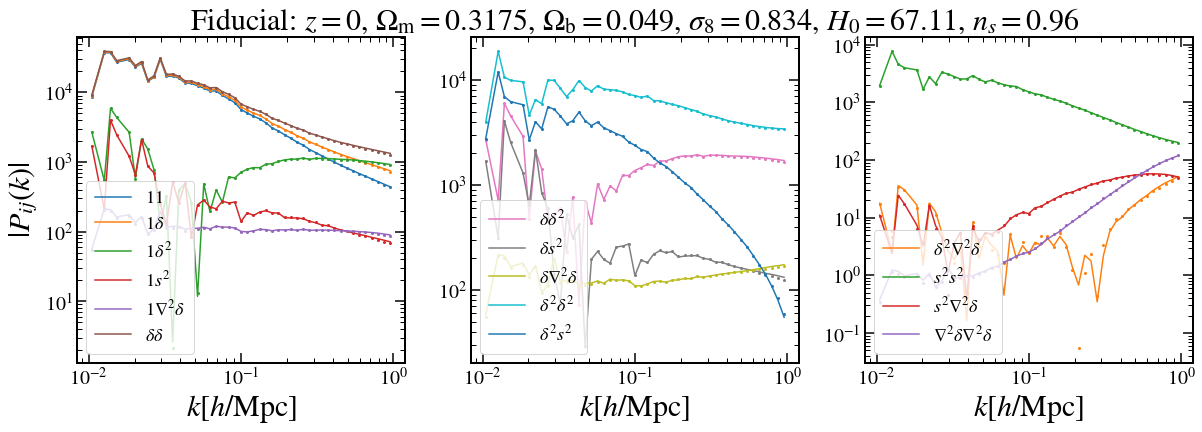

In [14]:
fig, ax = plt.subplots(1,3, figsize=(20,6))

labels = ['$1 1$',
 '$1 \\delta$',
 '$1 \\delta^2$',
 '$1 s^2$',
 '$ 1 \\nabla^2\\delta$',
 '$\\delta \\delta$',
 '$\\delta \\delta^2$',
 '$\\delta s^2$',
 '$\\delta \\nabla^2\\delta$',
 '$\\delta^2 \\delta^2$',
 '$\\delta^2 s^2$',
 '$\\delta^2 \\nabla^2\\delta$',
 '$s^2 s^2$',
 '$s^2 \\nabla^2\\delta$',
 '$\\nabla^2\\delta \\nabla^2\\delta$']

indices = range(0,15)

contf=0
for ii in indices:
    mask = np.abs(power_all_terms_sim[ii]['pk'])>0
    ax[contf].loglog(power_all_terms_pred[ii]['k'][mask], np.abs(power_all_terms_pred[ii]['pk'][mask]),
                       color='C'+str(ii), label=labels[ii])
    ax[contf].loglog(power_all_terms_pred[ii]['k'][mask], np.abs(power_all_terms_sim[ii]['pk'][mask]),
                       'o', markersize=2, color='C'+str(ii))

    ax[contf].legend(loc='lower left', frameon=True, fancybox=True)
    ax[contf].set_xlabel(r'$k[h/$Mpc]', size=30)
    if ii%5==0 and ii>0:
        contf+=1

ax[0].set_ylabel(r'$ |P_{ij}(k)| $', size=30)
#ax[0].set_ylim(10.,1e5)

ax[1].set_title(r'Fiducial: $z=0$, $\Omega_{\rm m}=0.3175$, $\Omega_{\rm b}=0.049$, $\sigma_8=0.834$, $H_0=67.11$, $n_s=0.96$',
                 fontsize=30)
plt.show()


### And that's it. Thanks for reading until here!

### Marcos :)